# J-Quants API Quick Startガイド

In [1]:
#@title 初期設定＆各種import
#@markdown ←にある▶ボタンを押すとGoogle Colabでコードを実行することができます。

#@markdown まずはこちらのコードを実行し、J-Quants APIを利用するため必要なパッケージをimportしましょう。

import json
import sys
import requests

from IPython.display import display
import pandas as pd

pd.set_option("display.max_columns", None)

API_URL = "https://api.jquants.com"

## Step1：API利用開始までの流れ　※初回のみ実施

J-Quants APIのご利用を検討いただき、ありがとうございます。

**J-Quants APIをご利用いただくには、以下の2つを事前に行っていただく必要がございます。**
 1. [J-Quants Webサイト](https://jpx-jquants.com/)への登録
 2. J-Quants API利用のためのプラン（Free, Light, Standard, Premium）選択

まだ、ご登録もしくはプラン選択がお済みでない方は、まず上記の2項目を行っていただきますようお願いいたします。  
より具体的な手順は[こちら](https://jpx.gitbook.io/j-quants-ja/outline/getstarted)をご参照ください。

##Step2及びStep3：リフレッシュトークン取得 & idToken取得
リフレッシュトークンを取得するには2つの方法があります。
1. J-Quants Webサイトへログインし、リフレッシュトークンを取得するボタンからリフレッシュトークンを取得する方法
2. リフレッシュトークン取得APIを利用し、リフレッシュトークンを取得する方法

以下に記載のどちらかお好みの方法でリフレッシュトークン及びidTokenを取得してください。

In [ ]:
#@title **1.J-Quants Webサイトから取得したリフレッシュトークンを貼り付ける場合**
#@markdown J-Quants Webサイトにて取得したリフレッシュトークンを以下の「ここにtextを挿入」の箇所に貼り付けてください。

refreshtoken = ""#@param {type: "string"}

# idToken取得
res = requests.post(f"{API_URL}/v1/token/auth_refresh?refreshtoken={refreshtoken}")
if res.status_code == 200:
    id_token = res.json()['idToken']
    headers = {'Authorization': 'Bearer {}'.format(id_token)}
    display("idTokenの取得に成功しました。")
else:
    display(res.json()["message"])


#@markdown 上記コードを実行し、**「idTokenの取得に成功しました。」**と表示されれば、J-Quants APIを利用するための準備は完了です。

#@markdown なお、 「Your refresh token may be incorrect or expired.」等のエラーが出力されている場合は、上記で貼り付けたリフレッシュトークンが誤っているか、期限が切れている可能性がございます。

#@markdown その場合はお手数ですが、再度リフレッシュトークンをJ-Quants Webサイトから取得いただき、再度実行してください。


###**2. J-Quants Webサイトに登録したID及びPWを使用し、RefreshToken及びidTokenをAPIを利用して取得する場合**

In [ ]:
#@title Google Driveのマウント

#@markdown 登録いただいたIDやPWを直接本Notebookに記載するのはセキュリティ上適切ではない可能性があるため、<br>
#@markdown Google Driveに設定ファイルを作成し、当該設定ファイルにIDやPWを記載することをおすすめします。

#@markdown 本コードを実行し、まずはGoogle Driveをマウントします。


from google.colab import drive

try:
    drive.mount('/content/drive')
except:
    print("Google Driveのマウントに失敗しました。")
else:
    print("Google Driveのマウントに成功しました。")

#### 設定ファイルの作成（初回のみ）
- 以下の画像のように 「drive→MyDrive→drive_ws→secret→jquants-api.toml」といった階層で設定ファイルを作成します。

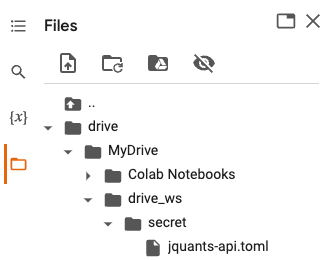

- 作成したtomlファイルに以下のサンプルのとおりID及びパスワードを記載します。  
(なお、\*の箇所はご登録いただいたID及びPWに置き換えてください。)

```
[jquants-api-client]
mailaddress = "*****@***.***"
password = "**************"
```

In [ ]:
#@title 作成した設定ファイルを読み込み、リフレッシュトークン及びidTokenを取得
#@markdown 正しく設定ファイルが作成されていれば、本コードを実行することで、idTokenを取得することができます。
#@markdown 「APIを使用する準備が完了しました。」と出力されれば、されれば、J-Quants APIをコールすることができるようになります！

if sys.version_info >= (3, 11):
    import tomllib
else:
    import tomli as tomllib

config_path = ("/content/drive/MyDrive/drive_ws/secret/jquants-api.toml")

with open(config_path, mode="rb") as f:
    ret = tomllib.load(f)["jquants-api-client"]

USER_DATA = {k: v for k, v in ret.items()}

# refresh token取得
try:
  res = requests.post(f"{API_URL}/v1/token/auth_user", data=json.dumps(USER_DATA))
  refresh_token = res.json()['refreshToken']
except:
  print("RefreshTokenの取得に失敗しました。")
else:
  # id token取得
  try:
    res = requests.post(f"{API_URL}/v1/token/auth_refresh?refreshtoken={refresh_token}")
    id_token = res.json()['idToken']
  except:
    print("idTokenの取得に失敗しました。")
  else:
    headers = {'Authorization': 'Bearer {}'.format(id_token)}
    print("API使用の準備が完了しました。")

## Step4：取得したIDトークンを用いて各APIをご利用ください。

### Freeプラン以上のプランで利用できるAPI
- 上場銘柄一覧（/listed/info）
- 株価四本値*（/prices/daily_quotes）
- 財務情報/fins/statements)
- 決算発表予定日（/fins/announcement）
- 取引カレンダー（/markets/trading_calendar）

\* プレミアムプランのユーザのみ、前後場の四本値及び取引高・取引代金の情報が取得可能


In [ ]:
#@title 上場銘柄一覧（/listed/info）

#@markdown - 過去時点での銘柄情報、当日の銘柄情報および翌営業日時点の銘柄情報が取得可能です。
#@markdown - データの取得では、銘柄コード（code）または日付（date）の指定が可能です。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の24:00頃

code = ""#@param {type:"string"}
date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/listed/info", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["info"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/listed/info", params=params, headers=headers)
    d = res.json()
    data += d["info"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 株価四本値（/prices/daily_quotes）

#@markdown - 株価は分割・併合を考慮した調整済み株価（小数点第２位四捨五入）と調整前の株価を取得することができます。
#@markdown - データの取得では、銘柄コード（code）または日付（date）の指定が必須となります。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の17:00頃

#@markdown - Premiumプランの方には、日通しに加え、前場(Morning)及び後場(Afternoon)の四本値及び取引高（調整前・後両方）・取引代金が取得可能です。


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/prices/daily_quotes", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["daily_quotes"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/prices/daily_quotes", params=params, headers=headers)
    d = res.json()
    data += d["daily_quotes"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 財務情報（/fins/statements）

#@markdown - 財務情報APIでは、上場企業がTDnetへ提出する決算短信Summary等を基に作成された、四半期毎の財務情報を取得することができます。
#@markdown - データの取得では、銘柄コード（code）または開示日（date）の指定が必須です。

#@markdown （データ更新時刻）
#@markdown - 速報18:00頃、確報24:30頃


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/fins/statements", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["statements"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/statements", params=params, headers=headers)
    d = res.json()
    data += d["statements"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 決算発表予定日（/fins/announcemnet）

#@markdown （データ更新時刻）
#@markdown - 不定期（更新がある日は）19:00頃

#@markdown - [当該ページ](https://www.jpx.co.jp/listing/event-schedules/financial-announcement/index.html)で、3月期・９月期決算会社分に更新があった場合のみ19時ごろに更新されます。

params = {}

res = requests.get(f"{API_URL}/v1/fins/announcement", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["announcement"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/announcement", params=params, headers=headers)
    d = res.json()
    data += d["announcement"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 取引カレンダー（/market/trading_calendar）

#@markdown - 東証およびOSEにおける営業日、休業日、ならびにOSEにおける祝日取引の有無の情報を取得できます。
#@markdown - データの取得では、休日区分（holidaydivision）または日付（from/to）の指定が可能です。

#@markdown （データ更新日）
#@markdown - 不定期（原則として、毎年2月頃をめどに翌年1年間の営業日および祝日取引実施日（予定）を更新します。）


holidaydivision = ""#@param ["0", "1", "2", "3"]{allow-input:true}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if holidaydivision != "":
  params["holidaydivision"] = holidaydivision
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/trading_calendar", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["trading_calendar"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/trading_calendar", params=params, headers=headers)
    d = res.json()
    data += d["trading_calendar"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

### Lightプラン以上のプランで利用できるAPI
- 投資部門別情報（/markets/trades_spec）
- TOPIX四本値（/indices/topix）

In [ ]:
#@title 投資部門別（株式）データ（/markets/trades_spec）

#@markdown - 投資部門別売買状況（金額）のデータを取得することができます。
#@markdown - 投資部門別売買状況は、個人・外国人・金融機関など、投資家ごとの売買動向をまとめた情報です。
#@markdown - 基本的には[こちら](https://www.jpx.co.jp/markets/statistics-equities/investor-type/index.html)のページで掲載しているものと同等のものになります。
#@markdown - データの取得では、セクション（section）または日付（from/to）の指定が可能です。

#@markdown （データ更新時刻）
#@markdown - 原則、毎週第４営業日18:00頃


section = ""#@param ["TSE1st", "TSE2nd", "TSEMothers", "TSEJASDAQ", "TSEPrime", "TSEStandard", "TSEGrowth", "TokyoNagoya"] {allow-input: true}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if section != "":
  params["section"] = section
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/trades_spec", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["trades_spec"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/trades_spec", params=params, headers=headers)
    d = res.json()
    data += d["trades_spec"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())


In [ ]:
#@title TOPIX四本値（/indices/topix）

#@markdown - 日次のTOPIX指数の四本値について取得することができます。
#@markdown - 日付（from/to）の指定が可能です

#@markdown （データ更新時刻）
#@markdown - 毎営業日の16:30頃


date_from = ""#@param {type:"string"}
date_to = ""#@param {type:"string"}

params = {}

if date_from != "":
  params["from"] = date_from
if date_to != "":
  params["to"] = date_to

res = requests.get(f"{API_URL}/v1/indices/topix", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["topix"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/indices/topix", params=params, headers=headers)
    d = res.json()
    data += d["topix"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())


### Standard以上のプランで利用できるAPI
- 指数四本値（/indices）
- オプション四本値（/option/index_option）
- 信用取引週末残高（/markets/weekly_margin_interest）
- 業種別空売り比率（/markets/short_selling）
- 空売り残高報告（/markets/short_selling_positions）
- 日々公表信用取引残高（/markets/daily_margin_interest）

In [ ]:
#@title 指数四本値（/indices）

#@markdown - 日次の各種指数の四本値について取得することができます。
#@markdown - データの取得では、指数コード（code）または日付（date）の指定が必須となります。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の16:30頃


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/indices", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["indices"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/indices", params=params, headers=headers)
    d = res.json()
    data += d["indices"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title オプション四本値（/option/index_option）

#@markdown - 日次の日経225指数オプションの四本値や売買高、清算値段等について取得することができます。
#@markdown - 日付（date）の指定が必須です

#@markdown （データ更新時刻）
#@markdown - 毎営業日の27:00頃


date = "" #@param {type:"string"}
params = {}
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/option/index_option", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["index_option"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/option/index_option", params=params, headers=headers)
    d = res.json()
    data += d["index_option"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 信用取引週末残高（/markets/weekly_margin_interest）

#@markdown - 制度・一般信用取引における各銘柄の前週末の残高についてデータを取得することができます。
#@markdown - 本データは[こちら](https://www.jpx.co.jp/markets/statistics-equities/margin/index.html)の個別銘柄信用取引残高表のデータをヒストリカルで提供するものになります。
#@markdown - 銘柄コード（code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toはcodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 原則毎週第２営業日の16:30頃


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/weekly_margin_interest", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["weekly_margin_interest"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/weekly_margin_interest", params=params, headers=headers)
    d = res.json()
    data += d["weekly_margin_interest"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 業種別空売り比率（/markets/short_selling）

#@markdown - 日次の３３業種別の空売りの売買代金について取得することができます。
#@markdown - ３３業種コード（sector33code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toは33SectorCodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 毎営業日の17:00頃

#@markdown （その他留意点）
#@markdown - 業種コード9999は、ETFやREIT等の３３業種に含まれない銘柄のものになります。


sector33code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if sector33code != "":
  params["sector33code"] = sector33code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/short_selling", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["short_selling"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/short_selling", params=params, headers=headers)
    d = res.json()
    data += d["short_selling"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 空売り残高報告（/markets/short_selling_positions）

#@markdown - 「有価証券の取引等の規制に関する内閣府令」に基づき、取引参加者より報告を受けたもののうち、残高割合が0.5％以上のものについての情報を取得できます。
#@markdown - データの取得では、銘柄コード（code）、公表日（disclosed_date）、計算日（calculated_date）のいずれかの指定が必須となります。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の17:30頃

code = ""#@param {type:"string"}
disclosed_date = ""#@param {type:"string"}
disclosed_date_from = ""#@param {type:"string"}
disclosed_date_to = ""#@param {type:"string"}
calculated_date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if disclosed_date != "":
  params["disclosed_date"] = disclosed_date
if disclosed_date_from != "":
  params["disclosed_date_from"] = disclosed_date_from
if disclosed_date_to != "":
  params["disclosed_date_to"] = disclosed_date_to
if calculated_date != "":
  params["calculated_date"] = calculated_date

res = requests.get(f"{API_URL}/v1/markets/short_selling_positions", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["short_selling_positions"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/short_selling_positions", params=params, headers=headers)
    d = res.json()
    data += d["short_selling_positions"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 日々公表信用取引残高（/markets/daily_margin_interest）

#@markdown - 東京証券取引所または日本証券金融が、日次の信用取引残高を公表する必要があると認めた銘柄のみが収録されます。
#@markdown - データの取得では、銘柄コード（code）、公表日（date）のいずれかの指定が必須となります。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の16:30頃

code = ""#@param {type:"string"}
_date = ""#@param {type:"string"}
_from = ""#@param {type:"string"}
_to = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if _date != "":
  params["date"] = _date
if _from != "":
  params["from"] = _from
if _to != "":
  params["to"] = _to

res = requests.get(f"{API_URL}/v1/markets/daily_margin_interest", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["daily_margin_interest"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/daily_margin_interest", params=params, headers=headers)
    d = res.json()
    data += d["daily_margin_interest"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

### Premiumプランで利用できるAPI
- 売買内訳データ（/markets/breakdown）
- 前場四本値（/prices/AM）
- 配当金情報（/fins/dividend）
- 財務諸表(BS/PL)（/fins/fs_details）
- 先物四本値（/derivatives/futures）
- オプション四本値（/derivatives/options）

In [ ]:
#@title 売買内訳データ（/markets/breakdown）

#@markdown - 売買内訳データは、東証上場銘柄の東証市場における銘柄別の日次売買代金・売買高(立会内取引に限る)について、信用取引や空売りの利用に関して、発注時のフラグ情報を用いて細分化したデータです。
#@markdown - 銘柄コード（code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toはcodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 毎営業日の18:00頃

#@markdown （その他留意点）
#@markdown - 当日に立会内取引が成立しなかった場合（約定なし）、当該銘柄はレコードに含まれていません。

code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/markets/breakdown", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["breakdown"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/markets/breakdown", params=params, headers=headers)
    d = res.json()
    data += d["breakdown"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 前場四本値*（/prices/AM）

#@markdown - 各銘柄の前場の四本値及び取引高・代金について、当日の前場終了後のデータを取得できます。
#@markdown - 銘柄コード（code）を指定することができます。codeパラメータがない場合は、全銘柄取得されます。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の12:00頃

#@markdown （その他留意点）
#@markdown - 本APIのデータは当日12:00頃〜翌日の朝6:00頃まで取得可能です。
#@markdown - 当日以外のヒストリカルのデータは、Premiumユーザの方は株価四本値（/prices/daily_quotes）のAPIで取得可能です。
#@markdown - なお、上記以外の時間にAPIコールした場合は、StatusCode = 210が返却されます。（通常は200）


code = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code

res = requests.get(f"{API_URL}/v1/prices/prices_am", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["prices_am"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/prices/prices_am", params=params, headers=headers)
    d = res.json()
    data += d["prices_am"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 配当金情報（/fins/dividend）

#@markdown - 上場会社の配当（決定・予想）に関する１株当たり配当金額、基準日、権利落日及び支払開始予定日等の情報が取得できます。
#@markdown - 銘柄コード（code）もしくは日付（date）の指定が必須です。<br>
#@markdown （From, Toはcodeを入れている場合にのみ可能）

#@markdown （データ更新時刻）
#@markdown - 毎営業日の19:00頃


code = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = "" #@param {type:"string"}
to = "" #@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to != "":
  params["to"] = to

res = requests.get(f"{API_URL}/v1/fins/dividend", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["dividend"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/dividend", params=params, headers=headers)
    d = res.json()
    data += d["dividend"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 財務諸表(BS/PL)（/fins/fs_details）

#@markdown - 財務諸表(BS/PL)APIでは、上場企業の四半期毎の財務情報における、貸借対照表、損益計算書に記載の項目を取得することができます。
#@markdown - 本コードでは、出力結果の表示方法をformat_typeを指定して切り替え可能です。flat:全項目をヘッダーに表示する、non-flat:詳細項目を1列に集約します。
#@markdown - データの取得では、銘柄コード（code）または開示日（date）の指定が必須です。

#@markdown （データ更新時刻）
#@markdown - 速報18:00頃、確報24:30頃


format_type = "non-flat"#@param ["non-flat", "flat"]
code = ""#@param {type:"string"}
date = ""#@param {type:"string"}

params = {}
if code != "":
  params["code"] = code
if date != "":
  params["date"] = date

res = requests.get(f"{API_URL}/v1/fins/fs_details", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["fs_details"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/fins/fs_details", params=params, headers=headers)
    d = res.json()
    data += d["daily_quotes"]
  if format_type == "non-flat":
    df = pd.DataFrame(data)
  else:
    df = pd.json_normalize(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title 先物四本値（/derivatives/futures）

#@markdown - 先物四本値APIでは、先物に関する、四本値や清算値段、理論価格に関する情報を取得することができます。
#@markdown - データの取得では、日付（date）の指定が必須です。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の27:00頃

category = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = ""#@param{type:"string"}
to_ = ""#@param{type:"string"}
contract_flag = ""#@param{type:"string"}

params = {}
if category != "":
  params["category"] = category
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to_ != "":
  params["to"] = to_
if contract_flag != "":
  params["contract_flag"] = contract_flag

res = requests.get(f"{API_URL}/v1/derivatives/futures", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["futures"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/derivatives/futures", params=params, headers=headers)
    d = res.json()
    data += d["futures"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())

In [ ]:
#@title オプション四本値（/derivatives/options）

#@markdown - オプション四本値APIでは、オプションに関する、四本値や清算値段、理論価格に関する情報を取得することができます。
#@markdown - データの取得では、日付（date）の指定が必須です。

#@markdown （データ更新時刻）
#@markdown - 毎営業日の27:00頃

category = ""#@param {type:"string"}
date = ""#@param {type:"string"}
from_ = ""#@param{type:"string"}
to_ = ""#@param{type:"string"}
contract_flag = ""#@param{type:"string"}

params = {}
if category != "":
  params["category"] = category
if date != "":
  params["date"] = date
if from_ != "":
  params["from"] = from_
if to_ != "":
  params["to"] = to_
if contract_flag != "":
  params["contract_flag"] = contract_flag

res = requests.get(f"{API_URL}/v1/derivatives/options", params=params, headers=headers)

if res.status_code == 200:
  d = res.json()
  data = d["options"]
  while "pagination_key" in d:
    params["pagination_key"] = d["pagination_key"]
    res = requests.get(f"{API_URL}/v1/derivatives/options", params=params, headers=headers)
    d = res.json()
    data += d["options"]
  df = pd.DataFrame(data)
  display(df)
else:
  print(res.json())